
# Trabajo Grupal: Algoritmos de Segmentación

## Integrantes:

- **Godoy Bonillo, Giocrisrai**
- **Ordoñez Marín, César Augusto**
- **Álvarez González, Fátima del Rosario**
- **Castillo Quenaya, Luis Miguel**

## Cargar las librerías necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2gray, label2rgb
from skimage import data
from skimage.filters import gaussian, sobel
from skimage.segmentation import (active_contour, felzenszwalb, quickshift, 
                                 mark_boundaries, slic, clear_border, chan_vese,
                                  watershed)

from skimage.future.graph import rag_mean_color, cut_normalized, graph_merge
from skimage import io
# para cargar las imagenes
from matplotlib.pyplot import imread
from itertools import product

from skimage.util import img_as_float
import matplotlib.cm as cm

## Funciones Proporcionadas 
### Evalua la medida de precisión que tiene un test

In [2]:
# Defino una función para mostrar una imagen por pantalla con el criterio que considero más acertado
def imshow(img, title=''):
    fig, ax = plt.subplots(figsize=(7, 7))
    # El comando que realmente muestra la imagen
    ax.imshow(img, cmap=plt.cm.gray)
    # Para evitar que aparezcan los números en los ejes
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_title(title)
    plt.show()

### Función para comparar cómo de buena es una determinada segmentación en comparación con el ground truth


In [3]:
# Ambas imagenes deben contener valores True/False

def factor_f_evaluation(binary_image, ground_truth):
    TP = np.sum(np.logical_and(binary_image, ground_truth))
    TN = np.sum(np.logical_and(np.logical_not(binary_image), np.logical_not(ground_truth)))
    FP = np.sum(np.logical_and(np.logical_not(binary_image), ground_truth))
    FN = np.sum(np.logical_and(binary_image, np.logical_not(ground_truth)))
    P = TP/np.float(TP+FP)
    R = TP/np.float(TP+FN)
    if P+R == 0:
        F = 0
    else:
        F = 2*P*R/(P+R)
    return F

## Funciones Globales

### Se construyen las siguientes funciones globales para aplicarla los diferentes algoritmos.

#### Función obtiene los mejores resultados a partir de la imagen de validación vs la imagen en escala de gris  resultante del algoritmo de  segmentación utilizado.

In [4]:
def mejor_evaluacion (gray_img, gt_img, threshold=.1): 

    # threshold nos quedamos con aquel factor f que está por encima del 10% (suficientemente grande)
    # lista para mantener los indices a partir de la aplicación de np.unique
    results_eval = []
    # Se genera un indice para luego recuperar los valores más fácil desde la imagen en grises.
    for idx, item in enumerate(np.unique(gray_img)):
        # Se aplica F1 Score
        aux = factor_f_evaluation(gray_img==item, gt_img)
        # Se valida si el obtenido de F1 es mayor que threshold
        if aux > threshold:
            results_eval.append(idx)
            
    return results_eval      
      

#### Función que genera una imagen a partir de los segmentos mejor evaluados

In [5]:
def validar_resultado (gray_img, results_eval):
    init_image = np.zeros(gray_img.shape)
    for idx in results_eval:
        init_image = init_image+(gray_img == np.unique(gray_img)[idx])
    return init_image

#### Función devuele la imagen segmentada y el resultado de la evaluación respecto a la imagen de referencia

In [6]:
def validacion_final (gray_img, gt_img):
    best_evalution = mejor_evaluacion (gray_img, gt_img)
    resultado = validar_resultado(gray_img, best_evalution)
    evaluacion = factor_f_evaluation(resultado>0, gt_img)
    return resultado, evaluacion

#### Función devuele la imagen segmentada y el resultado de la evaluación respecto a la imagen de referencia

In [7]:
def segmentacion_escala_grises (img, labels,mode='similarity'):
    # Calcula la media de los segmentos adyacentes
    qs_rmc = rag_mean_color(img, labels, mode='similarity')
    # Aplicación de contorno solo para demostración
    imshow(mark_boundaries(img, labels), 'Aplicación de máscara a imagen original')
    # Se aplica cut_normalized para obtener una imagen recortada en base a su similitud
    # nuevo array de labels
    labels2 = cut_normalized(labels, qs_rmc, 15) 
    # Se genera una imagen con el nuevo array de labels
    out_qs = label2rgb(labels2, img, kind='avg', bg_label=0)
    # Se aplica el filtro de bordes al nuevo array
    out_qs = mark_boundaries(out_qs, labels2, (0, 0, 0))
    # Convertir los valores a escala de grises
    gray_out_qs = rgb2gray(out_qs)
    return gray_out_qs

#### Cargamos nuestras imagenes a trabajar

In [8]:
# https://lmb.informatik.uni-freiburg.de/resources/datasets/moseg.en.html
patos = io.imread('ducks01_0100.jpg')
gt_patos = rgb2gray(io.imread('ducks01_0100_gt.pbm'))<1
patos_float = img_as_float(patos)

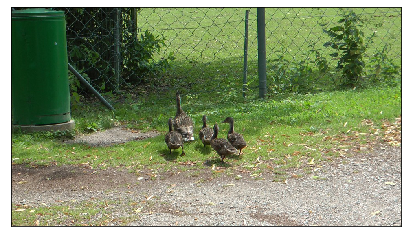

In [9]:
imshow(patos)

# Aplicación de Segmentación

## 1. Algoritmo Quickshift
- **se crea mascara de segmentación con el algoritmo quickshift.**
- **Se ha probado el algoritmo con diversos parámetros para su configuración**

In [10]:
label_qs = quickshift(
    patos,
    kernel_size=12, 
    max_dist=50, 
    sigma=0
)

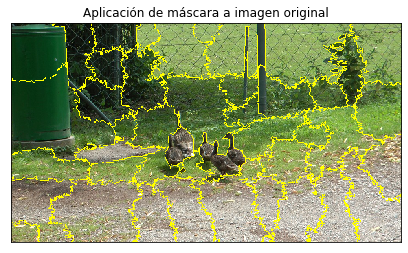

In [11]:
gray_out = segmentacion_escala_grises(patos, label_qs)

In [12]:
# Obtiene valores final luego del procesamiento de la imagen original
init_image_qs, evalucion_qs = validacion_final(gray_out, gt_patos)

## Resultado de la segmentacion

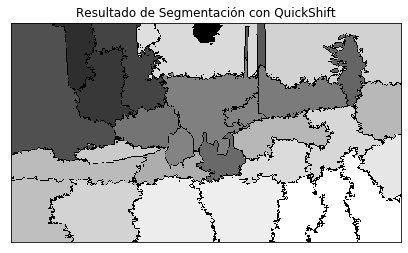

In [13]:
imshow(gray_out, 'Resultado de Segmentación con QuickShift')

## Resultado Final

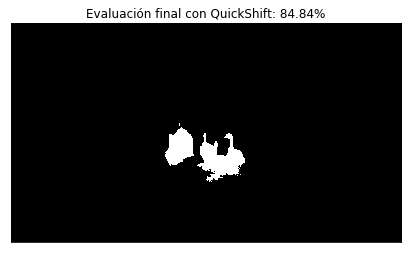

In [14]:
imshow(init_image_qs, 'Evaluación final con QuickShift: {0}%'.format(round(evalucion_qs, 4)*100))

## 2. Algoritmo Slic
- **se crea mascara de segmentación con el algoritmo Slic.**
- **Se ha probado el algoritmo con diversos parámetros para su configuración**

In [15]:
labels_slic = slic(patos, n_segments=32, compactness=29, sigma=2)

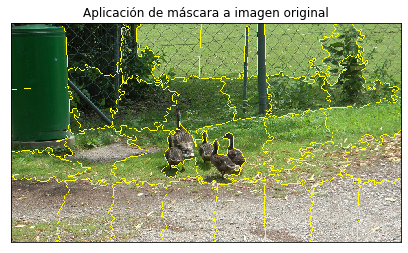

In [16]:
gray_out_slic = segmentacion_escala_grises(patos, labels_slic)

In [17]:
# Obtiene valores final luego del procesamiento de la imagen original 
init_image_slic, evalucion_slic = validacion_final(gray_out_slic, gt_patos)

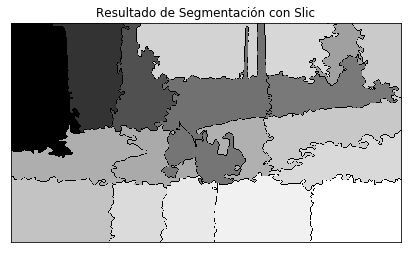

In [18]:
imshow(gray_out_slic, 'Resultado de Segmentación con Slic')

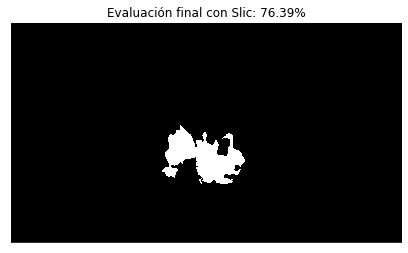

In [19]:
imshow(init_image_slic, 'Evaluación final con Slic: {0}%'.format(round(evalucion_slic, 4)*100))

## 3. Algoritmo felzenszwalb
- **se crea mascara de segmentación con el algoritmo felzenszwalb.**
- **Se ha probado el algoritmo con diversos parámetros para su configuración**

In [20]:
labels_fz = felzenszwalb(patos,
                           scale=410,
                           sigma=1, 
                           min_size=700
                          )

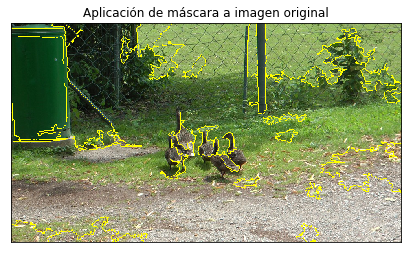

In [21]:
gray_out_fz = segmentacion_escala_grises(patos, labels_fz)

In [22]:
# Obtiene valores final luego del procesamiento de la imagen original 
init_image_fz, evalucion_fz = validacion_final(gray_out_fz, gt_patos)

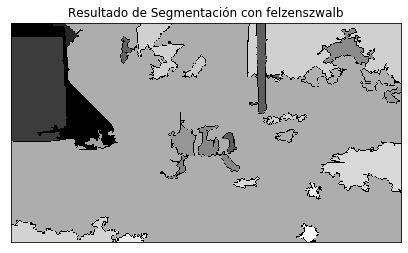

In [23]:
imshow(gray_out_fz, 'Resultado de Segmentación con felzenszwalb')

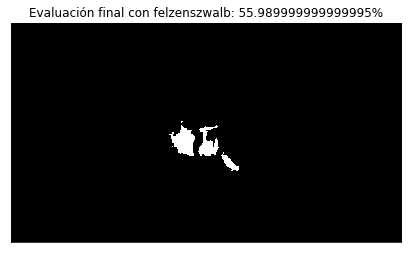

In [24]:
imshow(init_image_fz, 'Evaluación final con felzenszwalb: {0}%'.format(round(evalucion_fz, 4)*100))

## 4. Algoritmo watershed
- **se crea mascara de segmentación con el algoritmo felzenszwalb.**
- **Se ha probado el algoritmo con diversos parámetros para su configuración**

In [25]:
gradient = sobel(rgb2gray(patos))
labels_watershed= watershed(gradient, markers=500, compactness=0.009)

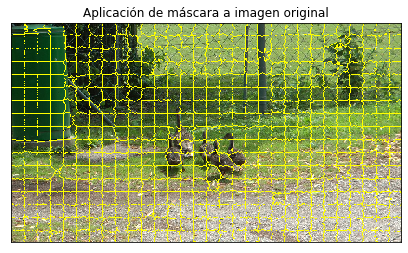

In [26]:
gray_out_watershed = segmentacion_escala_grises(patos, labels_watershed)

In [27]:
# Obtiene valores final luego del procesamiento de la imagen original 
init_image_watershed, evalucion_watershed = validacion_final(gray_out_watershed, gt_patos)

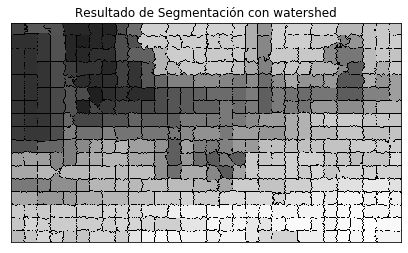

In [28]:
imshow(gray_out_watershed, 'Resultado de Segmentación con watershed')

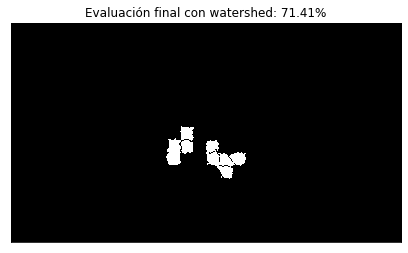

In [29]:
imshow(init_image_watershed, 'Evaluación final con watershed: {0}%'.format(round(evalucion_watershed, 4)*100))

# Comparación de Graficas de Resultados

## Grafica #1  - Metodo SLIC

Durante las pruebas se observa lo siguiente:
- El parámetro Compactness intercambia similitud de color y proximidad, como en el caso de Quickshift, con un rango de valor alto se observa que se genera un crecimiento de regiones o una fusion de segmentos.
- Mientras que n_segments elige el número de centros para k-means, con un intervalo entre 30 y 33 se consigue que la segmentacion capture correctamente la parte especifica de la imagen de patos, un valor superior al intervalo hallado se consigue un mayor numero de segmentos, dado que si es muy alto se pierde el enfoque de las areas deseadas mientras un valor muy bajo se consigue capturar mas areas de la imagen de lo requerido.

Numero de segmentos con SLIC: 32
Evaluación final con Slic: 76.39%


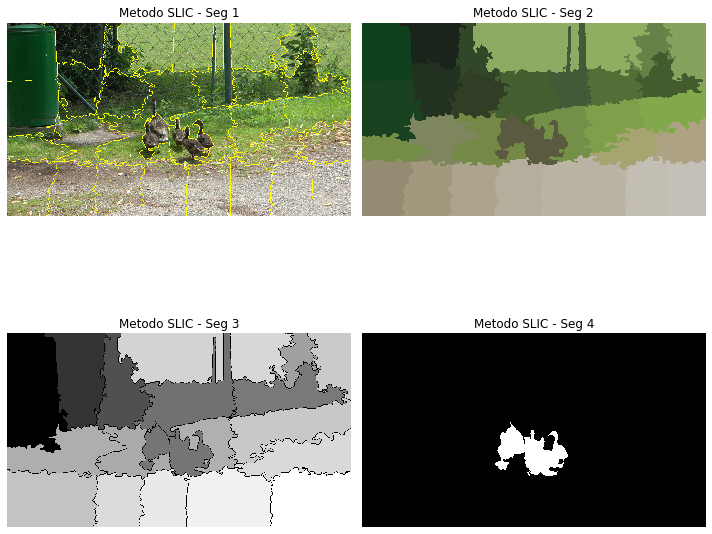

In [30]:
print(f"Numero de segmentos con SLIC: {len(np.unique(labels_slic))}")
print('Evaluación final con Slic: {0}%'.format(round(evalucion_slic, 4)*100))

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

out1_slic= label2rgb(labels_slic, patos_float, kind="avg")

ax[0, 0].imshow(mark_boundaries(patos_float, labels_slic))
ax[0, 0].set_title("Metodo SLIC - Seg 1")
ax[0, 1].imshow(out1_slic)
ax[0, 1].set_title('Metodo SLIC - Seg 2')
ax[1, 0].imshow(gray_out_slic,cmap=cm.gray)
ax[1, 0].set_title('Metodo SLIC - Seg 3')
ax[1, 1].imshow(init_image_slic,cmap=cm.gray)
ax[1, 1].set_title('Metodo SLIC - Seg 4')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

Nota: Trabajar con superpíxeles en lugar del espacio de cuadrícula de píxeles estándar nos proporciona eficiencia computacional, significado perceptivo, sobresegmentación y representaciones gráficas eficientes en las regiones de la imagen.

## Grafica #2 - Metodo QUICKSHIFT

Uno de los beneficios es que calcula una segmentación jerárquica en múltiples escalas simultáneamente y esto permite obtener buenos resultados, sin embargo cuando se ejecuta el algoritmo se observa un alto consumo coste computacional por parte del ordenador a diferencia de los demas metodos.

Numero de segmentos con QUICKSHIFT: 46
Evaluación final con QUICKSHIFT: 84.84%


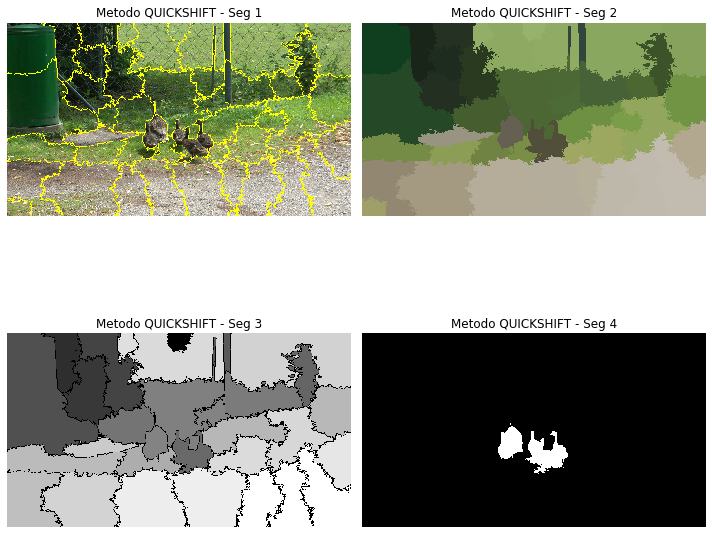

In [31]:
print(f"Numero de segmentos con QUICKSHIFT: {len(np.unique(label_qs))}")
print('Evaluación final con QUICKSHIFT: {0}%'.format(round(evalucion_qs, 4)*100))

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

out1_shift= label2rgb(label_qs, patos_float, kind="avg")

ax[0, 0].imshow(mark_boundaries(patos_float, label_qs))
ax[0, 0].set_title("Metodo QUICKSHIFT - Seg 1")
ax[0, 1].imshow(out1_shift)
ax[0, 1].set_title('Metodo QUICKSHIFT - Seg 2')
ax[1, 0].imshow(gray_out,cmap=cm.gray)
ax[1, 0].set_title('Metodo QUICKSHIFT - Seg 3')
ax[1, 1].imshow(init_image_qs,cmap=cm.gray)
ax[1, 1].set_title('Metodo QUICKSHIFT - Seg 4')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

## Grafica #3 - Metodo Felzenszwalb

Numero de segmentos con Felzenszwalb: 35
Evaluación final con Felzenszwalb: 55.989999999999995%


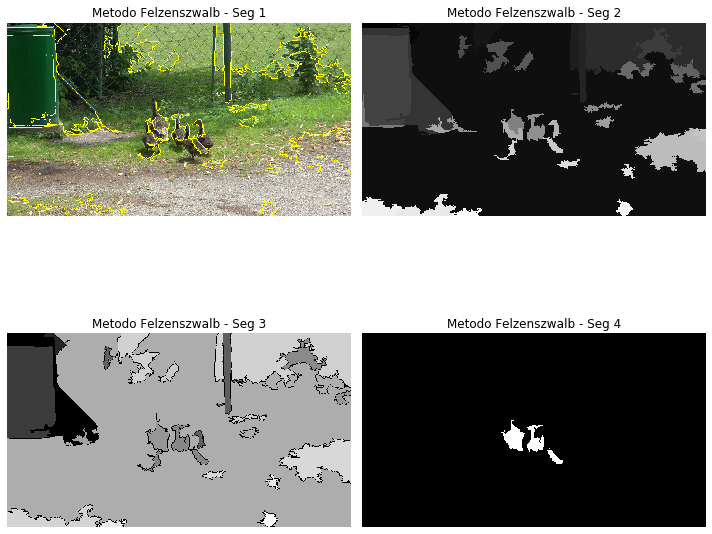

In [32]:
evalucion_fz=factor_f_evaluation(init_image_fz>0,gt_patos)

print(f"Numero de segmentos con Felzenszwalb: {len(np.unique(labels_fz))}") 
print('Evaluación final con Felzenszwalb: {0}%'.format(round(evalucion_fz, 4)*100))

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(patos_float, labels_fz))
ax[0, 0].set_title("Metodo Felzenszwalb - Seg 1")
ax[0, 1].imshow(labels_fz,cmap=cm.gray)
ax[0, 1].set_title('Metodo Felzenszwalb - Seg 2')
ax[1, 0].imshow(gray_out_fz,cmap=cm.gray)
ax[1, 0].set_title('Metodo Felzenszwalb - Seg 3')
ax[1, 1].imshow(init_image_fz,cmap=cm.gray)
ax[1, 1].set_title('Metodo Felzenszwalb - Seg 4')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

## Grafica #4 - Metodo Watershed

Numero de segmentos con Watershed: 510
Evaluación final con Watershed: 71.41%


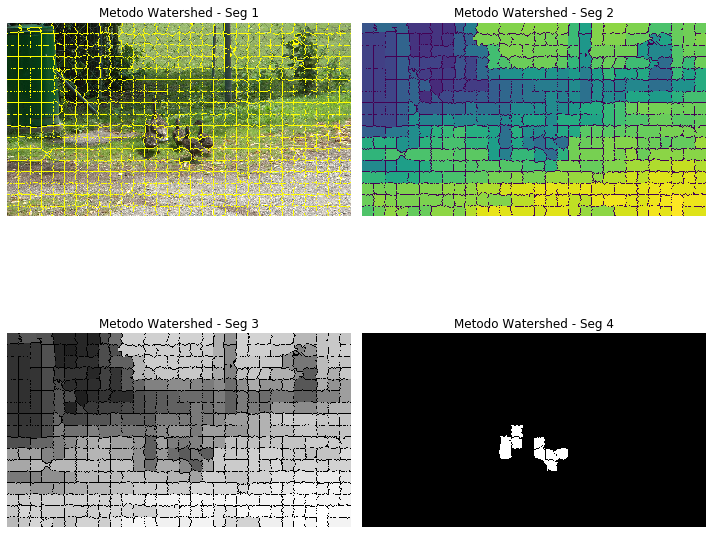

In [33]:
evalucion_water=factor_f_evaluation(init_image_watershed>0,gt_patos)

print(f"Numero de segmentos con Watershed: {len(np.unique(labels_watershed))}")
print('Evaluación final con Watershed: {0}%'.format(round(evalucion_water, 4)*100))

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

gray_out_watershed = rgb2gray(gray_out_watershed)

ax[0, 0].imshow(mark_boundaries(patos_float, labels_watershed))
ax[0, 0].set_title("Metodo Watershed - Seg 1")
ax[0, 1].imshow(gray_out_watershed)
ax[0, 1].set_title('Metodo Watershed - Seg 2')
ax[1, 0].imshow(gray_out_watershed,cmap=cm.gray)
ax[1, 0].set_title('Metodo Watershed - Seg 3')
ax[1, 1].imshow(init_image_watershed,cmap=cm.gray)
ax[1, 1].set_title('Metodo Watershed - Seg 4')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

## Graficas - Comparacion de resultados finales

Evaluación final con Slic: 76.39%
Evaluación final con QUICKSHIFT: 84.84%
Evaluación final con Felzenszwalb: 55.989999999999995%
Evaluación final con Watershed: 71.41%


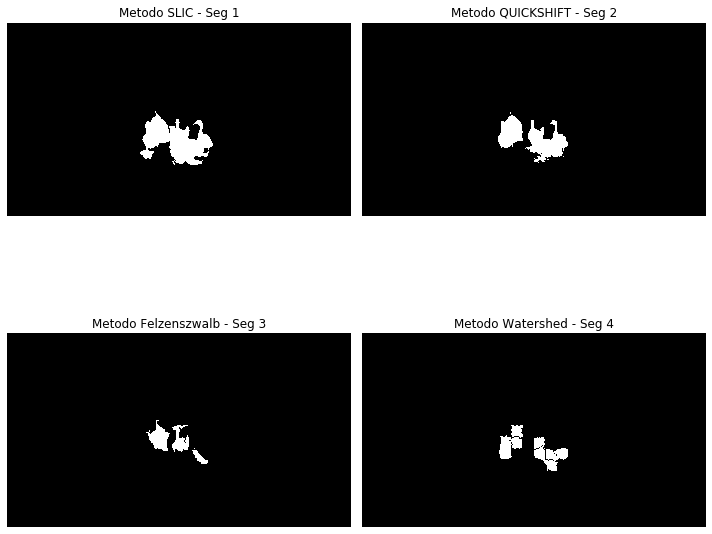

In [34]:
print('Evaluación final con Slic: {0}%'.format(round(evalucion_slic, 4)*100))
print('Evaluación final con QUICKSHIFT: {0}%'.format(round(evalucion_qs, 4)*100))
print('Evaluación final con Felzenszwalb: {0}%'.format(round(evalucion_fz, 4)*100))
print('Evaluación final con Watershed: {0}%'.format(round(evalucion_water, 4)*100))

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(init_image_slic,cmap=cm.gray)
ax[0, 0].set_title("Metodo SLIC - Seg 1")
ax[0, 1].imshow(init_image_qs,cmap=cm.gray)
ax[0, 1].set_title('Metodo QUICKSHIFT - Seg 2')
ax[1, 0].imshow(init_image_fz,cmap=cm.gray)
ax[1, 0].set_title('Metodo Felzenszwalb - Seg 3')
ax[1, 1].imshow(init_image_watershed,cmap=cm.gray)
ax[1, 1].set_title('Metodo Watershed - Seg 4')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

De la siguiente grafica de graficas se observa que segun los aciertos obtenidos, destaca el metodo SLIC y QUICKSHIT se consigue mejores resultados con respecto a los metodos Felzenswalb y Watershed.

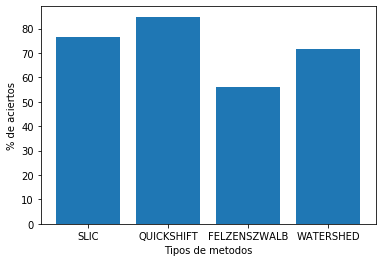

In [35]:
X = ["SLIC","QUICKSHIFT","FELZENSZWALB","WATERSHED"]
Y = [round(evalucion_slic, 4)*100,
     round(evalucion_qs, 4)*100,
     round(evalucion_fz, 4)*100,
     round(evalucion_water, 4)*100]

plt.bar(X, Y)
plt.xlabel('Tipos de metodos')
plt.ylabel('% de aciertos')

plt.show()

## Conclusiones

- De acuerdo a la evaluación de los distintos algoritmos `["SLIC","QUICKSHIFT","FELZENSZWALB","WATERSHED"]` 
realizamos una evaluación del comportamiento tanto númerico como visual de los mismos. 
- Fue necesario evaluar de forma individual los parametros entrada de cada uno de  los algoritmos, como se explica en detalle en las diferentes gráficas de evaluación.
- Para obtener mejores resultados es importante resaltar que aplicamos una máscara a `imshow(mark_boundaries(img, labels)` a la imagen en escala de grise lo que permitió una mayor definición en la segmentación.
- Dentro de nuestra evaluación pudimos percatarnos que cada uno de los algoritmos se evaluaron hasta generar unos valores umbrales, por lo tanto valor por encima o de debajo de este umbral genera un descenso de la calidad de la imagen resultante previamente obtenida.
- Comprobamos que el resultado final se obtiene mejor con `"SLIC","QUICKSHIFT"` y que a pesar de conseguir buena evaluación con `"FELZENSZWALB","WATERSHED"` la imagen resultante no logro la segmentación esperada.

### Tabla de valoración individual

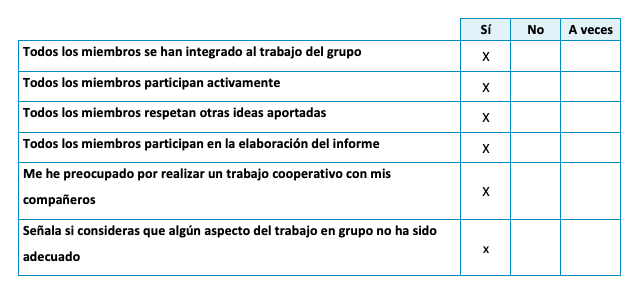